# Modelling and Evaluation Notebook

## Objectives

Create a model to analyse OCT images to evaluate the condition of macula distingishing between 4 conditions: Normal, CNV, DNV, DRUSEN. This answers business requirement 2.

## Inputs

Data is divided in three folders: train, val, test with following paths:

1. inputs/OCTdata/train
2. inputs/OCTdata/val
3. inputs/OCTdata/test

Additionally, a pkl file with image shaping obtained in the image_visualisation notebook.

## Outputs

1. Images distribution plot in train, validation, and test set.
2. Image augmentation.
3. Class indices to change prediction inference in labels.
4. Machine learning model creation and training.
5. Save model.
6. Learning curve plot for model performance.
7. Model evaluation on pickle file.
8. Prediction on the random image file.




# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

Finding the curent working directory

In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader/jupiter_notebooks'

Moving it to the workspace directory

In [3]:
os.chdir('/workspace/OCTreader')
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader'

Now we define paths for the train, val, test folders

In [4]:
split_dirs = os.listdir('inputs/OCTdata')
split_paths = {
    split_dirs[0]: 'inputs/OCTdata/' + split_dirs[0],
    split_dirs[1]: 'inputs/OCTdata/' + split_dirs[1],
    split_dirs[2]: 'inputs/OCTdata/' + split_dirs[2]
}
labels = os.listdir(split_paths[split_dirs[0]])

## Recall image shape

In [21]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f'outputs/{version}/image_shape.pkl')
image_shape

[498, 680, 3]

## Data availability

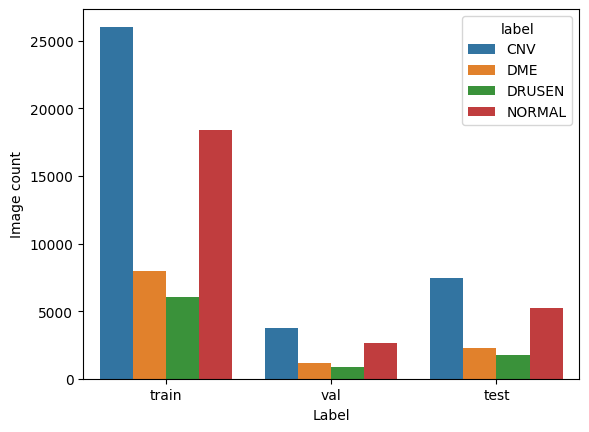

In [29]:
def data_availability_per_label(split_dir):
    '''
    Exploring the either train, val or test directoties
    counts the number of files per label

    '''
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for label in labels:
        image_labels = os.listdir(split_paths[split_dir] + '/' + label)
        count = 0
        for image_name in image_labels:
            count += 1
        df = df.append({'split_dir': split_dir, 'label': label, 'count': count},
                       ignore_index=True)

    return df


def data_availability():
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for split_dir in split_dirs:
        df2 = data_availability_per_label(split_dir)
        df = df.append(df2)
    ax = sns.barplot(data=df, x='split_dir', y='count', hue='label')
    ax.set(xlabel='Label', ylabel='Image count')
    plt.show()

data_availability()

## Data Augmentation

### Creating ImageDataGenerator

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Train dataset augmentation

In [32]:
batch_size = 10
train_set = augmented_image_data.flow_from_directory(split_paths['train'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 58525 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Validation dataset augmentation

In [33]:
val_set = augmented_image_data.flow_from_directory(split_paths['train'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

val_set.class_indices

Found 58525 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Test dataset augmentation

In [34]:
test_set = augmented_image_data.flow_from_directory(split_paths['train'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 58525 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

(10, 498, 680, 3)
[3. 0. 0. 1. 0. 0. 3. 1. 3. 0.]


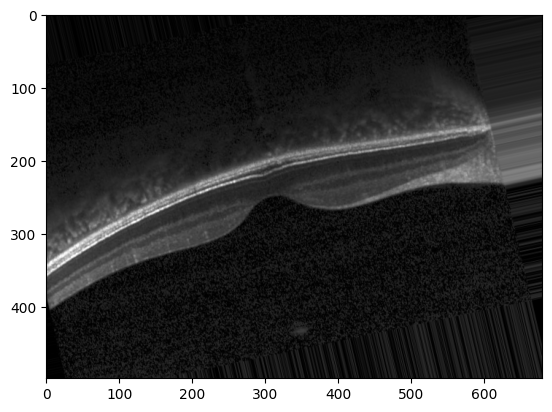

(10, 498, 680, 3)
[3. 0. 1. 1. 0. 0. 3. 2. 0. 0.]


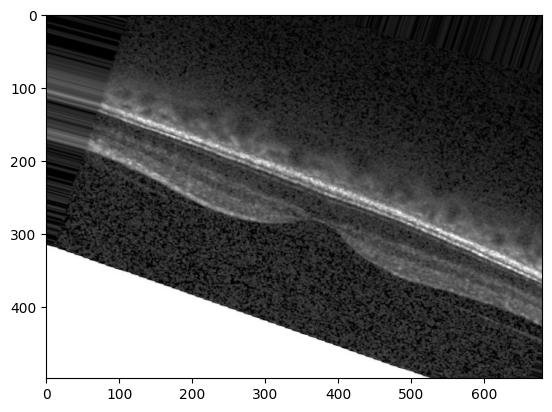

(10, 498, 680, 3)
[1. 0. 0. 1. 3. 0. 3. 3. 3. 3.]


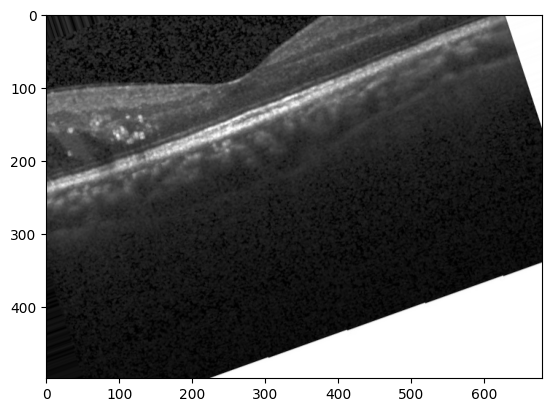

In [37]:
for i in range(3):
    img, label = train_set.next()
    print(img.shape)
    print(label)
    plt.imshow(img[0])
    plt.show()


## ML model

### Import model packages

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [47]:
def create_multiclas_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Print model summary

In [48]:
model = create_multiclas_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 496, 678, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 248, 339, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 246, 337, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 168, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 166, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 83, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 81, 64)       

### Adding early stop

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
patience = 3
early_stop = EarlyStopping(monitor='val_loss', patience=patience)


58525

# Fit model

In [51]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-03-11 17:25:42.242117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
   2/5852 [..............................] - ETA: 11:14:41 - loss: 0.4253 - accuracy: 0.2000

KeyboardInterrupt: 